In [1]:
#pip install polars 


In [2]:
import polars as pl 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns   
import pyarrow

In [3]:
reader_features = pl.read_csv_batched(
    "./data/predict_student_game_performance_train.csv"
)  
features_data = reader_features.next_batches(100)  


features_data = pl.concat(features_data)

In [4]:
reader_labels = pl.read_csv_batched(
    "./data/predict_student_game_performance_train_labels.csv"
)  
target_data = reader_labels.next_batches(100) 
target_data = pl.concat(target_data)
# extraire les premiers 17 caractères de la colonne 'session_id'

target_data = target_data.with_columns(pl.col("session_id").str.split("_").apply(lambda x: x[0]))

target_data = target_data.with_columns(pl.col("session_id").cast(pl.Int64))


In [26]:
data = features_data.join(target_data , on = "session_id" , how="inner")

In [27]:
data=data.to_pandas()

df = data.copy()
df = df.head(600000)
df = df.drop('index' , axis=1)

In [47]:
df.head()

,session_id,elapsed_time,event_name,name,level,room_fqid,fullscreen,hq,music,level_group,correct,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid
0,20090312431273200,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0,0,1,0-4,1,-413.991405,-159.314686,380.0,494.0,intro
1,20090312431273200,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0,0,1,0-4,1,-413.991405,-159.314686,380.0,494.0,intro
2,20090312431273200,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0,0,1,0-4,1,-413.991405,-159.314686,380.0,494.0,intro
3,20090312431273200,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0,0,1,0-4,1,-413.991405,-159.314686,380.0,494.0,intro
4,20090312431273200,0,cutscene_click,basic,0,tunic.historicalsociety.closet,0,0,1,0-4,1,-413.991405,-159.314686,380.0,494.0,intro


## Creation des sous-ensembles (suite au EDA)

In [28]:
missing_rate = df.isna().sum()/df.shape[0]


In [29]:
medium_na = df.columns[(missing_rate < 0.9) & (missing_rate > 0.50)]

In [30]:
little_na = df.columns[(missing_rate < 0.5) & (missing_rate > 0.05)]

In [31]:
zero_na = df.columns[(missing_rate == 0)]

In [25]:
 df = pd.concat([df[zero_na] , df[little_na] , df[medium_na]] , axis = 1)

Suite aux conclusions lors de la visualisation des features importances 

on décide de garder uniquement les variables présentes dans zero_na et little_na 

In [32]:
 df = pd.concat([df[zero_na] , df[little_na]] , axis = 1)

## TrainTesT - Nettoyage - Encodage 

In [13]:
#pip install scikit-learn


In [33]:
from sklearn.model_selection import train_test_split

In [53]:

trainset , testset = train_test_split(df, test_size=0.2, random_state=0)


In [54]:
trainset['correct'].value_counts(normalize=True)

correct
1    0.635279
0    0.364721
Name: proportion, dtype: float64

In [55]:
testset['correct'].value_counts(normalize=True)

correct
1    0.6347
0    0.3653
Name: proportion, dtype: float64

 ###  Encodage 

In [56]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

def encodage(df):
    """
    Encodes categorical variables in a DataFrame using LabelEncoder.
    Parameters:
        - df (pandas.DataFrame): The DataFrame to encode.
    Returns:
        - The encoded DataFrame.
    """
    d = defaultdict(LabelEncoder)
    df_cat = df.drop([ 'fqid'], axis=1).select_dtypes(include=['object'])
    
    # Encode categorical variables using LabelEncoder and store them in a dictionary
    df_cat_encoded = df_cat.apply(lambda x: d[x.name].fit_transform(x))
    
    # Replace the original categorical variables with their encoded versions
    for col in df_cat.columns:
        df[col] = df_cat_encoded[col]
    
    # Concatenate the encoded categorical variables with the rest of the DataFrame
    df_encoded = pd.concat([df_cat_encoded, df.select_dtypes(exclude=['object'])], axis=1)
    
    return df_encoded


 ###  Imputation 

In [57]:
def imputation(df):
    return df.dropna(axis=0)

####  Itération2 : pour améliorer notre modèle en augmentant les données de notre dataset 

    -- fillna + missing indicator pas top  : KO 
    

In [44]:
def imputation(df):
    return df.select_dtypes(include=['float']).fillna(-999)

# on remplace les Nas par une valeur extrème 

####  Itération3 : pour améliorer notre modèle en faisan une sélection de variables grace à la feature importances 

In [58]:
def preprocessing(df):
    df = encodage(df)
    df = imputation(df)
    X = df.drop('correct' , axis=1)
    y = df['correct']

    print(y.value_counts())
    
    return X , y 

In [59]:
X_train , y_train = preprocessing(trainset)




correct
1    276117
0    158634
Name: count, dtype: int64


In [60]:
X_test , y_test = preprocessing(testset)

correct
1    68887
0    39680
Name: count, dtype: int64


## Modélisation 

On règle juste le dataset pour qu'ils marchent sur un modèle bidon 

- Un des modèles qui luttent contre l'overfitting c'est le RandomForest

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [70]:
#model = DecisionTreeClassifier(random_state=0)

model = RandomForestClassifier(random_state=0)

### Procédure d'évaluation 

In [63]:
from sklearn.metrics import  f1_score , confusion_matrix , classification_report
from sklearn.model_selection import learning_curve


In [72]:
def evaluation(model):
    model.fit(X_train , y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test , ypred))
    print(classification_report(y_test , ypred))

In [73]:
evaluation(model)

# Sur les 39680 élèves qui on échoué à une étape du jeu on a pu identifié que 15845 (40 % des cas ) avec ce modèle pas terrible 
# 
# mais c'est un premier modèle avec les opérations de bases  

[[15238 24442]
 [10479 58408]]
              precision    recall  f1-score   support

           0       0.59      0.38      0.47     39680
           1       0.70      0.85      0.77     68887

    accuracy                           0.68    108567
   macro avg       0.65      0.62      0.62    108567
weighted avg       0.66      0.68      0.66    108567



In [23]:
zero_na

Index(['session_id', 'elapsed_time', 'event_name', 'name', 'level',
       'room_fqid', 'fullscreen', 'hq', 'music', 'level_group', 'correct'],
      dtype='object')

In [24]:
little_na

Index(['room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'fqid'], dtype='object')

<Axes: >

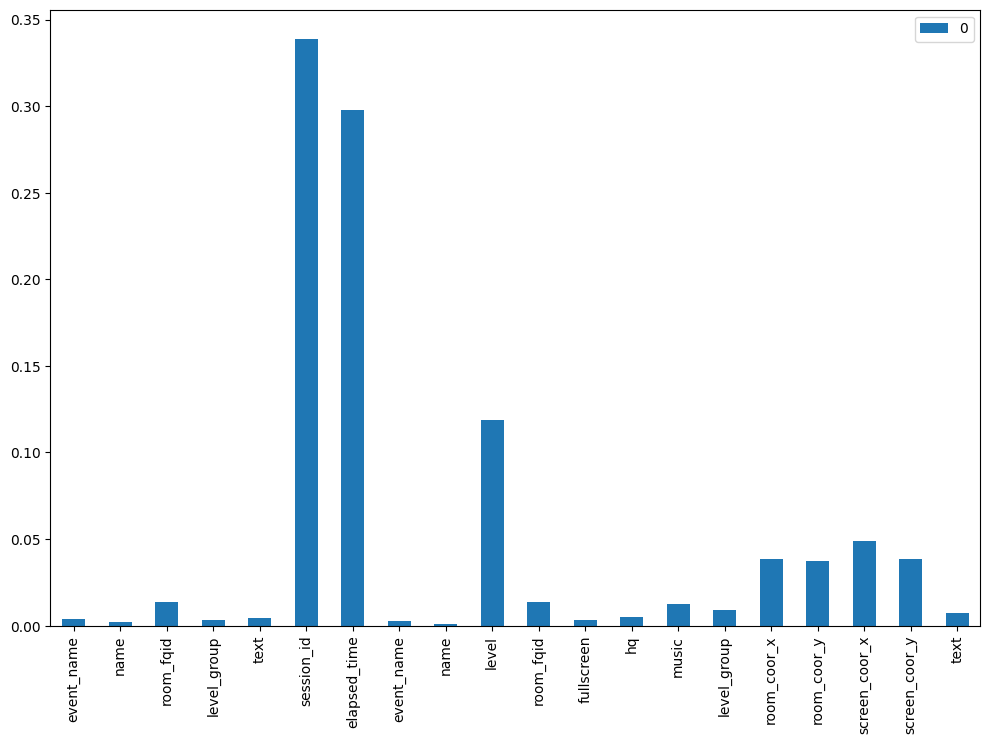

In [194]:
pd.DataFrame(model.feature_importances_ , index = X_train.columns).plot.bar(figsize=(12,8))

-- On remarque que les variables qui ne présente pas énorment de nans 

sont les variables qui ont le plus d'importance 

en l'occurence little_na et zero_na 

en effet deux variables de zero_na crèvent le plafond 
il s'agit de session_id et elapsed_time 
le level est pas mal non plus 


Hypothèse : on peut faire du feature engineer entre les variables vu précédememnt et les variables présentes dans little_nas 

- room_coor_x
- room_coor_y
- screen_coor_x
- screen_coor_y 

Conclusion  on va tout simplement réduire notre dataset et le restreindre aux variables de zero_na et little_na dans un premier temps 

ensuite on va  créer une variable en faisant une combinaison de certaines de ces variables 

On peut aussi définir un thresold (seuil) en dessous duquel les variables ne sont pas séléctionner .




On observe que le modèle est en overfitting 

pck notre modèle à bien appris sa leçon ok sur les les données d'entrainements 

par contre il es incapable de généraliser sur de nouveaux cas 
mais quand on  lui donne les données du validation set ie des données qu'il n'a pas vu lors de l'entrainement  il n'est pas performant 

Une chose qu'on peu faire pour lutter contre cet overfitting c'est de fournir plus de données à la machine (en général ça marche bien contre l'overfitting)

De plus on dirait qu'on ait entrain de monter progressivement plus on a de données plus le score sur la validation augmente





## Diagnostic de notre modèle 


*** grace à la 

learning curve qui permet  au modèle de s'entrainer et s'évaluer sur plusieurs splits de notre dataset 

In [74]:
def evaluation(model):
    model.fit(X_train , y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test , ypred))
    print(classification_report(y_test , ypred))
# le nombre d'échantillons qui ont servi à entrainer notre modèle
    N , train_score , val_score = learning_curve(model , X_train  , y_train , cv =4 , scoring='f1' , train_sizes=np.linspace(0.1 , 1, 10))

    plt.figure(figsize=(12,8))
    # l'évolution du trainscore en fonction du nombre d'échantillons qui ont servi à entrainer notre modèle 
    plt.plot(N , train_score.mean(axis=1) , label= train_score)
    plt.plot(N , val_score.mean(axis=1) , label= val_score)
    plt.legend()

[[15238 24442]
 [10479 58408]]
              precision    recall  f1-score   support

           0       0.59      0.38      0.47     39680
           1       0.70      0.85      0.77     68887

    accuracy                           0.68    108567
   macro avg       0.65      0.62      0.62    108567
weighted avg       0.66      0.68      0.66    108567



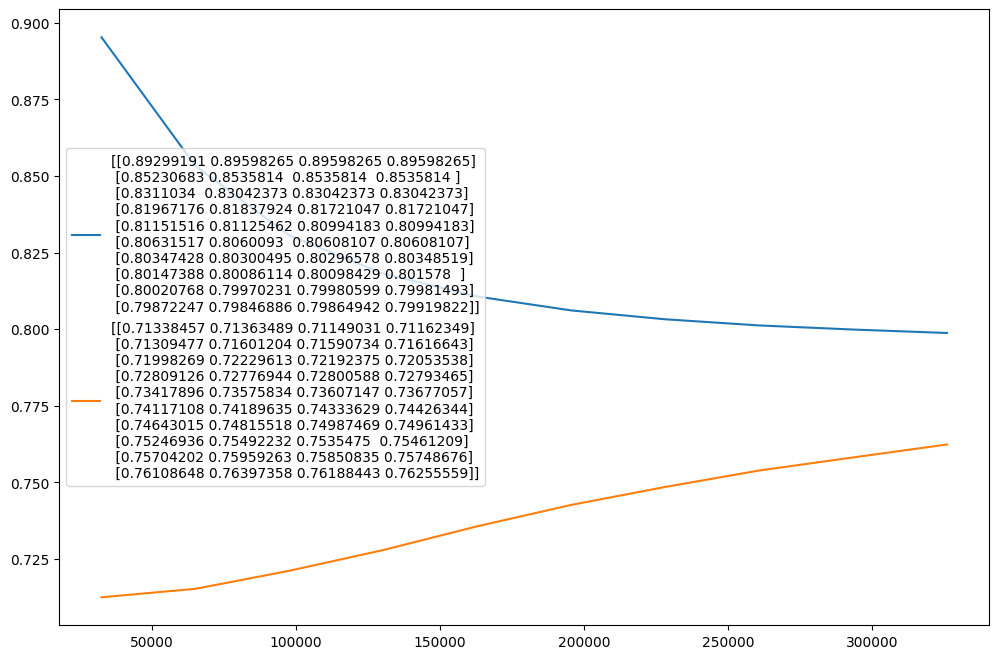

In [75]:
evaluation(model)

In [ ]:
import pandas as pd

df = pd.DataFrame({
   'level_group': ['0-4', '5-12', '13-22'],
   'event_name': ['cutscene_click', 'person_click', 'notification_click'],
   'name': ['basic', 'open', 'next']
})

encoded_df = pd.get_dummies(df, columns=['level_group', 'event_name', 'name'])
print(encoded_df)


In [20]:
import pandas as pd

df = pd.DataFrame({
   'room_fqid': ['tunic.historicalsociety.closet', 'tunic.historicalsociety.basement',
                 'tunic.historicalsociety.entry', 'tunic.historicalsociety.collection',
                 'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
                 'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty',
                 'tunic.historicalsociety.frontdesk', 'tunic.humanecology.frontdesk',
                 'tunic.drycleaner.frontdesk', 'tunic.library.frontdesk',
                 'tunic.library.microfiche', 'tunic.capitol_1.hall',
                 'tunic.historicalsociety.cage', 'tunic.historicalsociety.collection_flag',
                 'tunic.wildlife.center', 'tunic.flaghouse.entry', 'tunic.capitol_2.hall']
})

encoded_df = pd.get_dummies(df, columns=['room_fqid'])
print(encoded_df)


129868

In [21]:
76164 -43836

32328